# Sin wave RNN

## Activation Function

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

Training with activation: sigmoid


C:\Users\user\anaconda3\envs\Sin_wave\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training with activation: tanh
Training with activation: relu


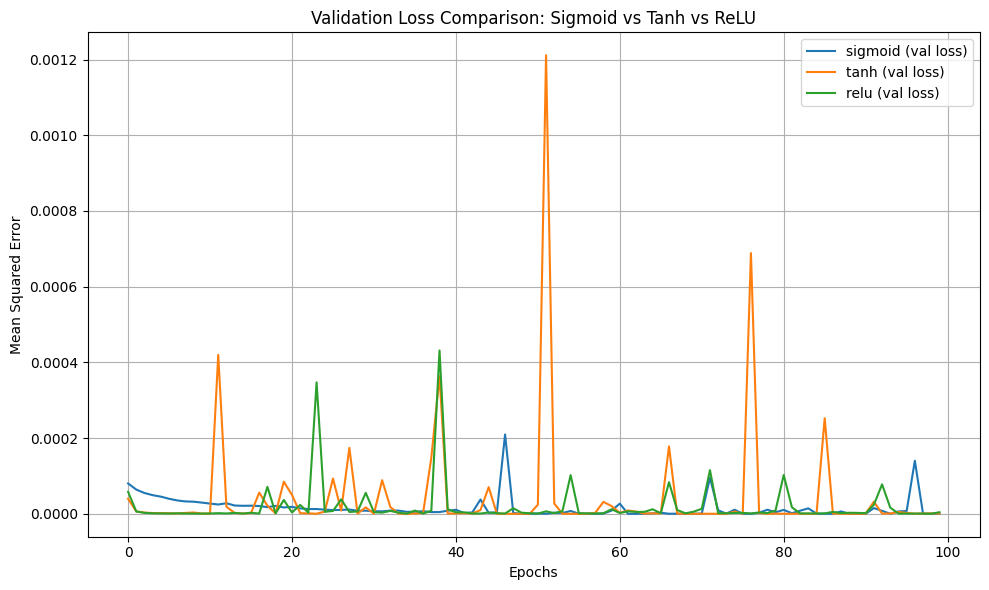

In [6]:
# 1. Load dataset
df = pd.read_csv("Sin_Wave_Data_Generator.csv")
wave_data = df['Wave'].values

# 2. Prepare data using a sliding window
def create_dataset(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 50
X, y = create_dataset(wave_data, window_size)

# 3. Normalize data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# 4. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# 5. Function to build and train model
def build_and_train_model(activation, epochs=100):
    model = Sequential([
        Dense(64, input_shape=(X_train.shape[1],), activation=activation),
        Dense(64, activation=activation),
        Dense(1)
    ])
    model.compile(optimizer=Adam(0.001), loss='mse')
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                        epochs=epochs, verbose=0)
    return history.history['loss'], history.history['val_loss']

# 6. Compare Sigmoid, Tanh, ReLU
activations = ['sigmoid', 'tanh', 'relu']
loss_histories = {}

for act in activations:
    print(f"Training with activation: {act}")
    train_loss, val_loss = build_and_train_model(act)
    loss_histories[act] = {'train': train_loss, 'val': val_loss}

# 7. Plot losses
plt.figure(figsize=(10, 6))
for act in activations:
    plt.plot(loss_histories[act]['val'], label=f'{act} (val loss)')
plt.title('Validation Loss Comparison: Sigmoid vs Tanh vs ReLU')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Training model with ReLU
Training model with Leaky ReLU


C:\Users\user\anaconda3\envs\Sin_wave\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Training model with Parametric ReLU


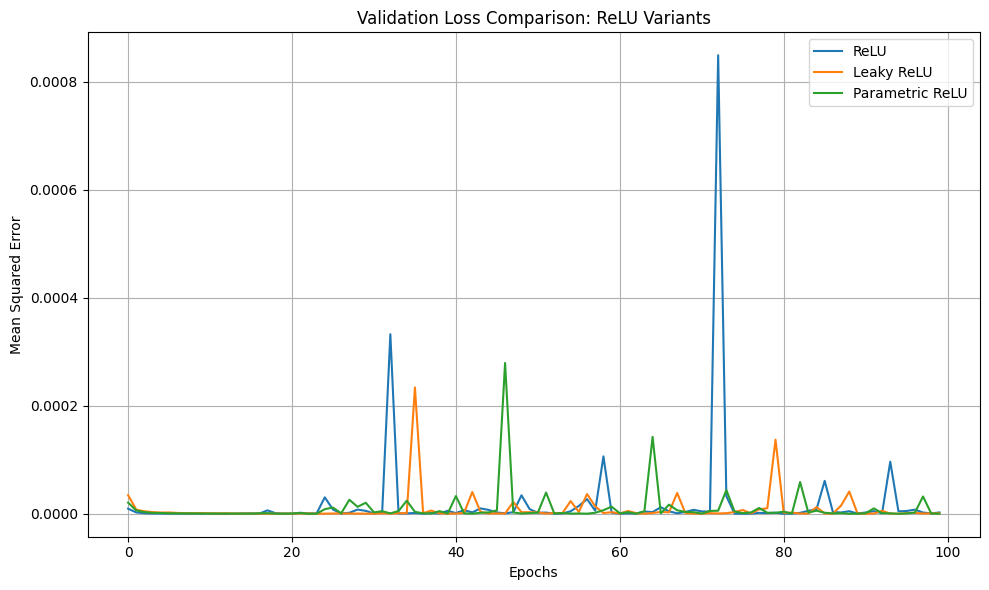

In [7]:
from tensorflow.keras.layers import LeakyReLU, PReLU

# Function to create and train model with flexible activation
def build_model_with_custom_activation(activation_layer, depth=2, epochs=100):
    model = Sequential()
    model.add(Dense(64, input_shape=(X_train.shape[1],)))
    model.add(activation_layer())

    for _ in range(depth - 1):
        model.add(Dense(64))
        model.add(activation_layer())
    
    model.add(Dense(1))  # Output layer
    model.compile(optimizer=Adam(0.001), loss='mse')
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                        epochs=epochs, verbose=0)
    return history.history['val_loss']

# Compare ReLU variants
relu_variants = {
    'ReLU': tf.keras.layers.ReLU,
    'Leaky ReLU': lambda: LeakyReLU(alpha=0.01),
    'Parametric ReLU': lambda: PReLU()
}

variant_losses = {}
for name, act_fn in relu_variants.items():
    print(f"Training model with {name}")
    loss = build_model_with_custom_activation(act_fn, depth=2)
    variant_losses[name] = loss

# Plot ReLU variant performance
plt.figure(figsize=(10, 6))
for name, loss in variant_losses.items():
    plt.plot(loss, label=f'{name}')
plt.title('Validation Loss Comparison: ReLU Variants')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Training with depth 1
Training with depth 2
Training with depth 3
Training with depth 4
Training with depth 5


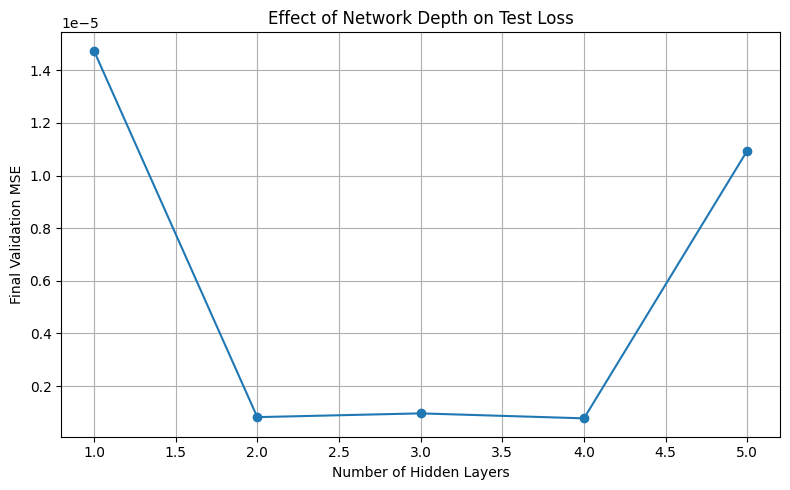

In [8]:
# Now explore depth (1 to 5 layers) with standard ReLU
depth_losses = {}
for d in range(1, 6):
    print(f"Training with depth {d}")
    loss = build_model_with_custom_activation(tf.keras.layers.ReLU, depth=d)
    depth_losses[d] = loss

# Plot performance vs depth
final_losses = [loss[-1] for loss in depth_losses.values()]

plt.figure(figsize=(8, 5))
plt.plot(list(depth_losses.keys()), final_losses, marker='o')
plt.title('Effect of Network Depth on Test Loss')
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Final Validation MSE')
plt.grid(True)
plt.tight_layout()
plt.show()